# OASIS-2 ALZHEIMER'S DETECTION

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import re
import psutil
import gc

### Importing demographic data:

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
df_demographics = pd.read_csv('/content/drive/MyDrive/projekat/oasis_longitudinal.csv')
df_demographics

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [68]:
#df_demographics['Group'] = df_demographics['Group'].replace(['Converted'], ['Demented'])

### Image data processing

- Loading MRI "nifti.img" files from directory, removing None values
- *nibabel* library to load MRI files  

In [69]:
rootdir = os.getcwd() + "/drive/MyDrive/OAS2_RAW_PART1"
print(rootdir)


mri_patients_scans_names = []
mri_ignored_file_names = []
mri_images = []
mri_images_data = []


/content/drive/MyDrive/OAS2_RAW_PART1


- count files in root directory

In [70]:

file_count = sum(len(files) for _, _, files in os.walk(rootdir))
print(f'Found {file_count} files in root directory.')

Found 3385 files in root directory.


- progress bar using tqdm
- loading MRI image using nibabel
- if the file type is not recognised, ignore it

In [71]:
def clearFilePath(path):
    file_name = path.split('/')[-3::2]
    return file_name[0]+'_'+file_name[1].split('-')[-1][0]



print('Loading MRI "nifti.img" files:')


with tqdm(total=file_count) as pbar:
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            filepath = os.path.join(subdir, file)

            if filepath.endswith("1.nifti.img") :
                try:
                    # Load the MRI image using nibabel
                    img = nib.load(filepath)
                    mri_images.append(img)

                    mri_patients_scans_names.append(clearFilePath(filepath))

                    mri_images_data.append(img.get_fdata())
                except nib.filebasedimages.ImageFileError as e:
                    # If the file type is not recognized, ignore the file and print a message
                    mri_ignored_file_names.append(filepath)
                    #print(
                       # f'File type not recognized - ignoring "{filepath}" file')

            pbar.update(1)

print(
    f'\nFound and loaded {len(mri_patients_scans_names)} MRI "nifti.img" files from "{rootdir}" subdirectories')
print(f'Ignored:')
print(*mri_ignored_file_names, sep=' ')
print(mri_patients_scans_names[0])


Loading MRI "nifti.img" files:


100%|██████████| 3385/3385 [01:16<00:00, 44.05it/s]


Found and loaded 373 MRI "nifti.img" files from "/content/drive/MyDrive/OAS2_RAW_PART1" subdirectories
Ignored:

OAS2_0002_MR2_1


In [72]:

# Get unique patient visit names from MRI file names
mri_patients_visits_names = np.unique(
    [re.sub('_\d\Z', '', i) for i in mri_patients_scans_names])

# Filter the demographics dataframe based on the MRI IDs
df_demographics = df_demographics[df_demographics['MRI ID'].isin( mri_patients_visits_names)]
print(df_demographics)
print("Before cleaning data from none values from demographics:")
print(
    f'Number of patients visits: {len(np.unique(mri_patients_visits_names))}')
print(f'Number of patients scans: {len(mri_patients_scans_names)}')
print(
    f'Number of slices of MRI scans : {np.unique([arr.shape[2] for arr in mri_images_data])}')


    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
..         ...            ...          ...    ...       ...  ..  ...  ...   
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   

     EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0      14  2.0  27.0  0.0  

In [73]:



# Drop rows in demographics dataframe with None values
df_drop = df_demographics[df_demographics.isna().any(axis =1)]
list_drop = df_drop['MRI ID'].tolist()
print(f'None value rows in demographics data to drop: {df_demographics.isnull().any(axis=1).sum()}')
df_demographics = df_demographics.dropna().reset_index(drop=True)

# Remove corresponding MRI files and names based on dropped rows
fname_drop = [fname for fname in mri_patients_scans_names if re.sub(
    '_\d\Z', '', fname) in list_drop]
fname_drop_id = [i for i in range(
    len(mri_patients_scans_names)) if mri_patients_scans_names[i] in fname_drop]

for i in reversed(fname_drop_id):
    del mri_images[i]
    del mri_patients_scans_names[i]
    del mri_images_data[i]

print(f"After cleaning data from none values from demographics:")
print(f"Number of removed MRI files: {len(fname_drop)}")
print(
    f"Number of patients visits: {len(np.unique(mri_patients_visits_names))}")
print(f"Number of patients scans: {len(mri_patients_scans_names)}")

None value rows in demographics data to drop: 19
After cleaning data from none values from demographics:
Number of removed MRI files: 19
Number of patients visits: 373
Number of patients scans: 354


### Visualizing MRI data

- shape of MRI scan

In [74]:
def get_patient_detail(index):
    mri_file_name = mri_patients_scans_names[index]
    patient_data = df_demographics[df_demographics['MRI ID'] == re.sub(
        '_\d\Z', '', mri_file_name)]
    return patient_data

In [75]:
mri_images_data[0].shape

(256, 256, 128, 1)

Shape of one MRI image:
(256, 256, 128, 1)


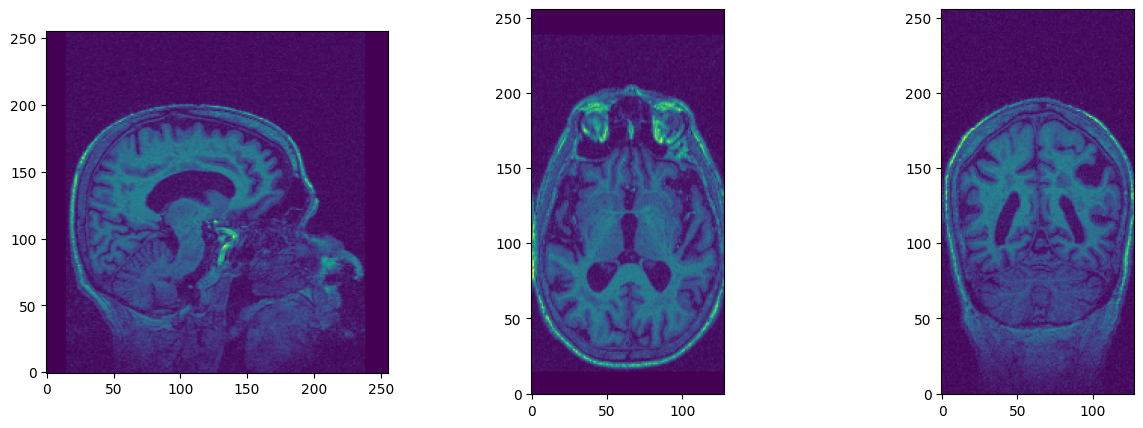

In [76]:
i = np.transpose(mri_images_data[0], (1, 0, 2, 3))
print("Shape of one MRI image:")
print(i.shape)
# Transpose the MRI image data to rearrange the dimensions for visualization

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(i[:, :, 75], origin='lower')
# Display the transposed MRI image slice at index 75


plt.subplot(132)
plt.imshow(i[120, :, :], origin='lower')
# Display a different slice of the transposed MRI image (at index 120)

plt.subplot(133)
plt.imshow(i[:,70 , :], origin='lower')
# Display another slice of the transposed MRI image (at index 70)

plt.show()


- Visualizing one MRI image and corresponding demographics data

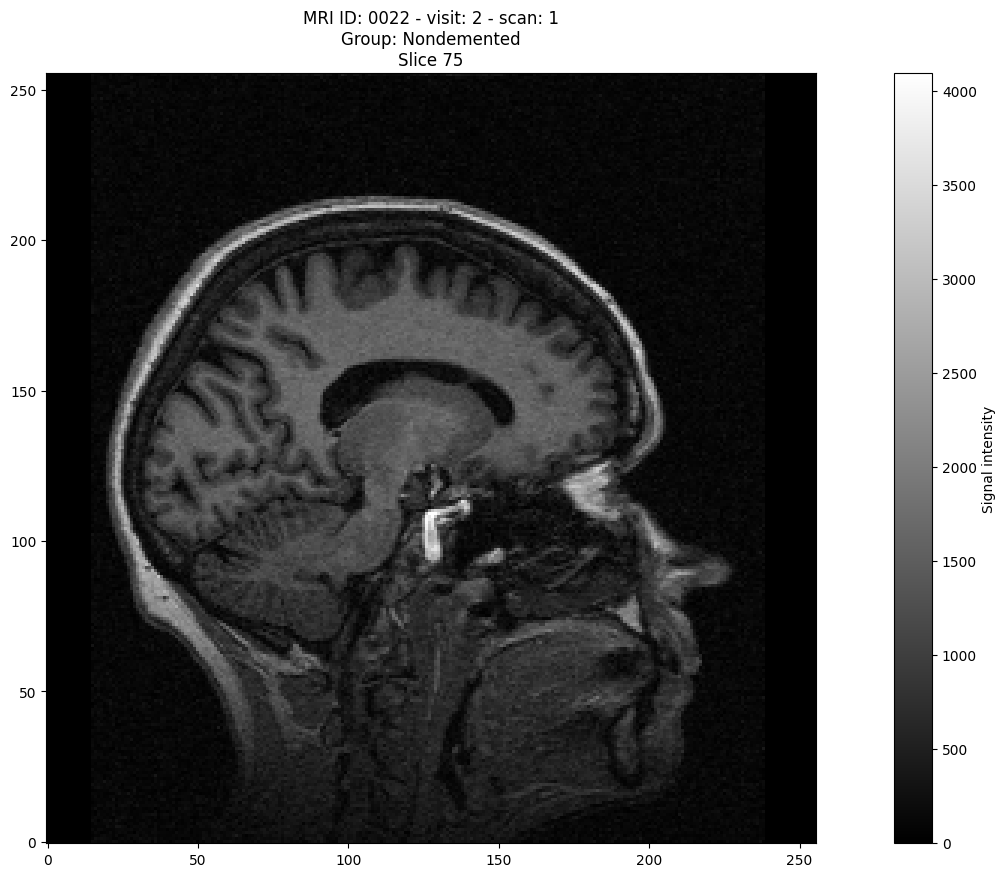

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
36,OAS2_0022,OAS2_0022_MR2,Nondemented,2,828,F,R,64,16,3.0,29.0,0.0,1316,0.796,1.333


In [77]:
image, s = 40, 75
# Define the image and slice indices to visualize
img_data = mri_images_data[image]

img_data = np.transpose(img_data, (1, 0, 2, 3))

mid_slice_x = img_data[:, :, s]

mri_file_name = mri_patients_scans_names[image]

patient_id = list(filter(None, re.split('_|MR', mri_file_name)))[1:]
# Extract the patient ID from the MRI file name using regex

patient_data = df_demographics[df_demographics['MRI ID'] == re.sub(
    '_\d\Z', '', mri_file_name)]
# Retrieve the demographics data for the patient ID obtained from the MRI file name

plt.figure(figsize=(20, 10))

plt.title(f'MRI ID: {patient_id[0]} - visit: {patient_id[1]} - scan: {patient_id[2]}\nGroup: {patient_data.iloc[0][2]}\nSlice {s}')
plt.imshow(mid_slice_x, cmap='gray', origin='lower')
plt.colorbar(label='Signal intensity')
plt.show()


patient_data
# Display the demographics data for the corresponding patient ID

- Visualizing 3 different dimentions

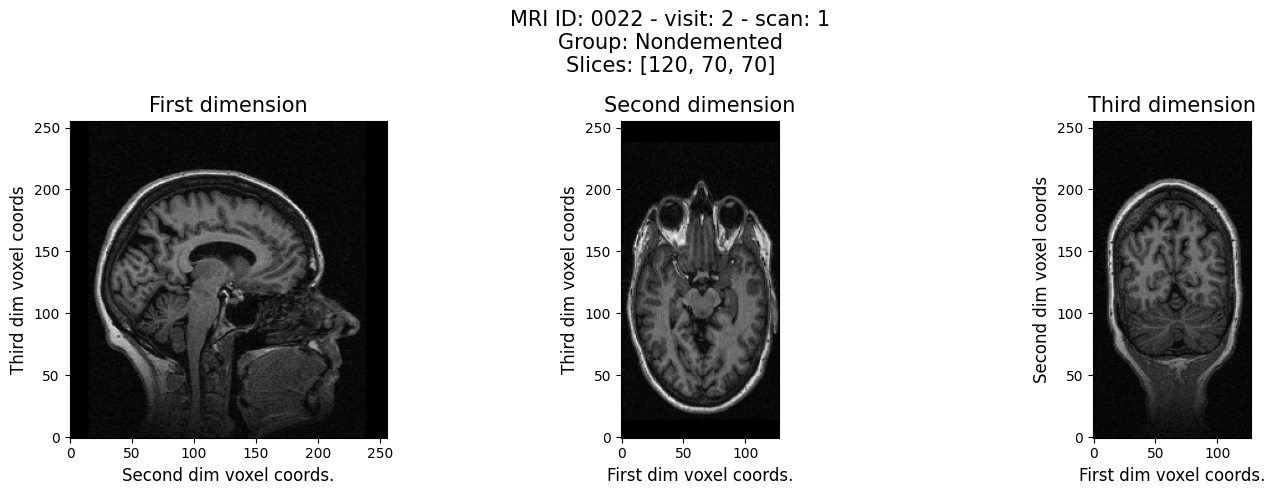

In [78]:
slice_no = [120, 70, 70]
# Define the slice numbers to visualize in each dimension

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))


ax[0].imshow(img_data[:, :, slice_no[2]], origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension', fontsize=15)


ax[1].imshow(img_data[slice_no[0], :, :], origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title(f'Second dimension', fontsize=15)

ax[2].imshow(img_data[:, slice_no[1], :], origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title(f'Third dimension', fontsize=15)


fig.suptitle(
    f'MRI ID: {patient_id[0]} - visit: {patient_id[1]} - scan: {patient_id[2]}\nGroup: {patient_data.iloc[0][2]}\nSlices: {slice_no}', fontsize=15)
# Set the super-title of the figure with relevant information, such as MRI ID, visit, scan, group, and the selected slice numbers

fig.tight_layout()
# Adjust the subplots layout to prevent overlapping

- 32 different scans , same slice

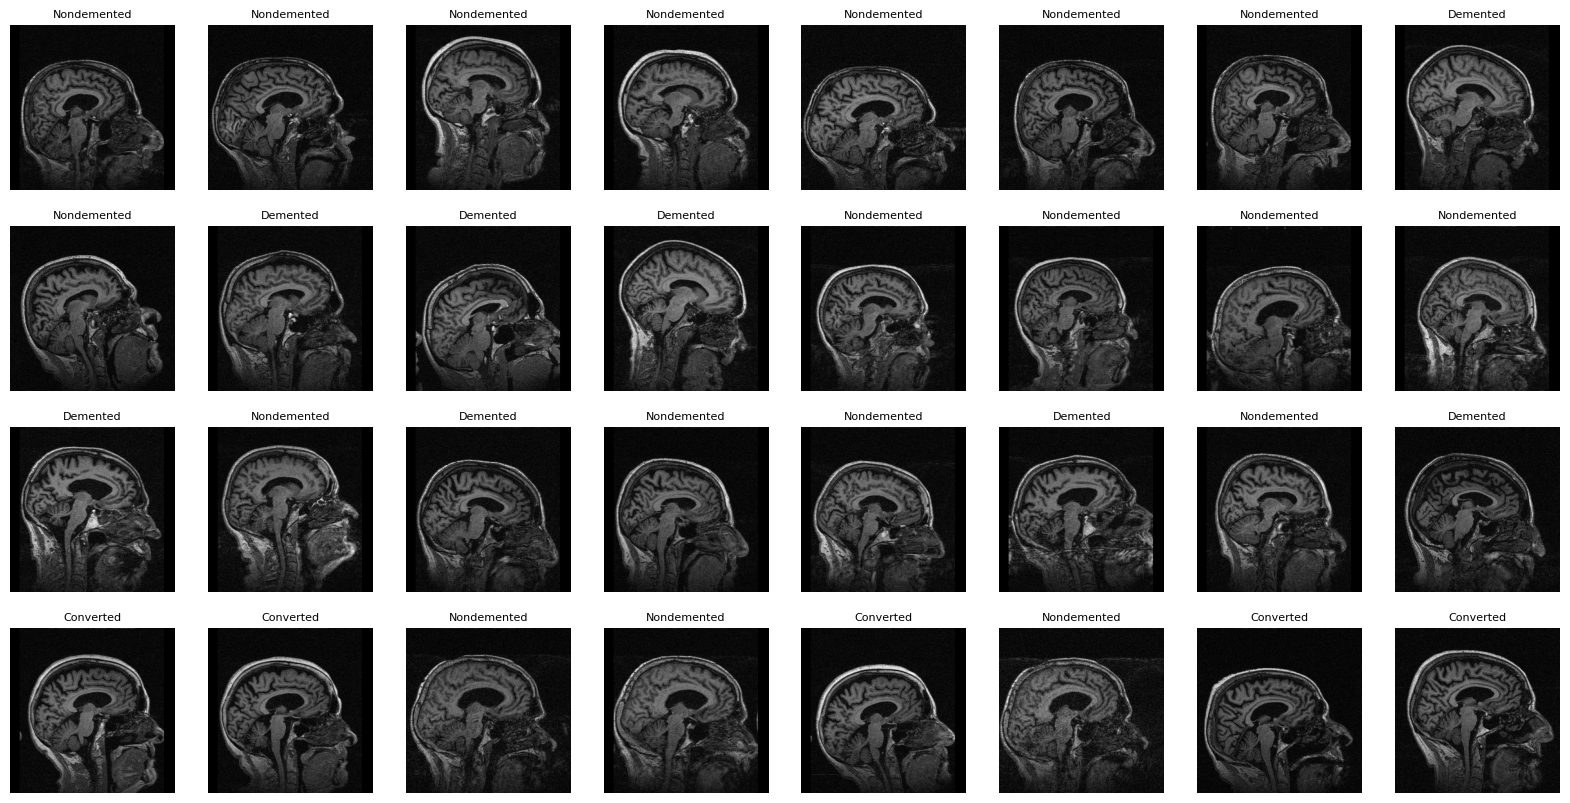

In [79]:
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))


for i in range(32):
    a = ax.flat[i]
    images = mri_images_data[i]
    images = np.transpose(images, (1, 0, 2, 3))
    a.imshow(images[:,:,70],origin='lower', cmap='gray', )
    a.set_title(get_patient_detail(i)['Group'].values[0],fontsize = 8)
    a.set_axis_off()

### Data Preprocessing


- encoding 3 different groups : Demented, Nondemented, Converted

In [80]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_demographics['Group'])

In [81]:
mri_images_data[0].shape

(256, 256, 128, 1)

- Encode the patient groups using label encoding

In [82]:
from tensorflow.keras.utils import to_categorical

cnn_y = []

for i in range(len(mri_images_data)):

    patient_group = get_patient_detail(i)['Group'].values[0]
    cnn_y.append(patient_group)

cnn_y = to_categorical(label_encoder.fit_transform(cnn_y))

- selects a subset of three consecutive slices (indexed 70, 71, and 72) from each MRI image in the mri_images_data array
- reshapes the subset to have a consistent shape of (256, 256, 3)

In [94]:
#np.concatenate((np.array(mri_images_data[0][:, :,70]),np.array(mri_images_data[0][:,70,:]), np.array(mri_images_data[0][70,:,:])))
#np.concatenate((np.array(mri_images_data[0][:, :,70]), np.array(mri_images_data[0][:,70,:]), mri_images_data[0][70,:,:]), axis = 2)
#print(mri_images_data[0][:, :,70].reshape(256,).shape)

mri_images_data_np = np.array([i[:, :, [75, 80, 85]].reshape(256, 256, 3) for i in mri_images_data])


In [95]:


print(f"{('Length if image data: ')}{len(mri_images_data)}")
print(f"{('Length of y: ')}{len(cnn_y)}")
print(f"{('shape of a image: ')}{mri_images_data_np[0].shape}")



Length if image data: 354
Length of y: 354
shape of a image: (256, 256, 3)


### Model - VGG16





- Importing pre-trained model

In [146]:
from tensorflow.keras import applications
import ssl
#from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50
ssl._create_default_https_context = ssl._create_unverified_context

input_shape = (256, 256, 3)
base_model = VGG16(
    weights="imagenet", include_top=False, input_shape=input_shape,)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

- freeze the models layers

In [147]:
for layer in base_model.layers:
    layer.trainable = False

In [148]:
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169

#model=Sequential()
#model.add(base_model)
#model.add(Dropout(0.5))
#model.add(Flatten())
#model.add(BatchNormalization())
#model.add(Dense(2048,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1024,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(2,activation='softmax'))


model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3,activation='softmax'))


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dropout_28 (Dropout)        (None, 8, 8, 512)         0         
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_35 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            (None, 512)              

- training and test data

In [149]:
from sklearn.model_selection import train_test_split

#  split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(
    mri_images_data_np, cnn_y, test_size=.25)

print(f"Train shape: {train_X.shape}")
print(f"Test shape: {test_X.shape}")

Train shape: (265, 256, 256, 3)
Test shape: (89, 256, 256, 3)


- training the model

In [150]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

METRIC = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),]

early_stopping = EarlyStopping(patience=80)
model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=METRIC)

# Train the new model with early stopping
hist = model.fit(train_X, train_y, validation_split=.2,
                     epochs =100, callbacks= [early_stopping], verbose = 1)

Epoch 1/100
7/7 [==============================] - 6s 348ms/step - loss: 1.6141 - accuracy: 0.5912 - precision: 0.3605 - recall: 0.2925 - auc: 0.5143 - val_loss: 1.9922 - val_accuracy: 0.5786 - val_precision: 0.3478 - val_recall: 0.3019 - val_auc: 0.5093
Epoch 2/100
7/7 [==============================] - 2s 257ms/step - loss: 1.5174 - accuracy: 0.5739 - precision: 0.3234 - recall: 0.2547 - auc: 0.5157 - val_loss: 1.3041 - val_accuracy: 0.6478 - val_precision: 0.4595 - val_recall: 0.3208 - val_auc: 0.5790
Epoch 3/100
7/7 [==============================] - 2s 260ms/step - loss: 1.3494 - accuracy: 0.6289 - precision: 0.4294 - recall: 0.3443 - auc: 0.5963 - val_loss: 1.1589 - val_accuracy: 0.6855 - val_precision: 0.5429 - val_recall: 0.3585 - val_auc: 0.6106
Epoch 4/100
7/7 [==============================] - 2s 262ms/step - loss: 1.2113 - accuracy: 0.6651 - precision: 0.4972 - recall: 0.4245 - auc: 0.6621 - val_loss: 1.1293 - val_accuracy: 0.6667 - val_precision: 0.5000 - val_recall: 0.358

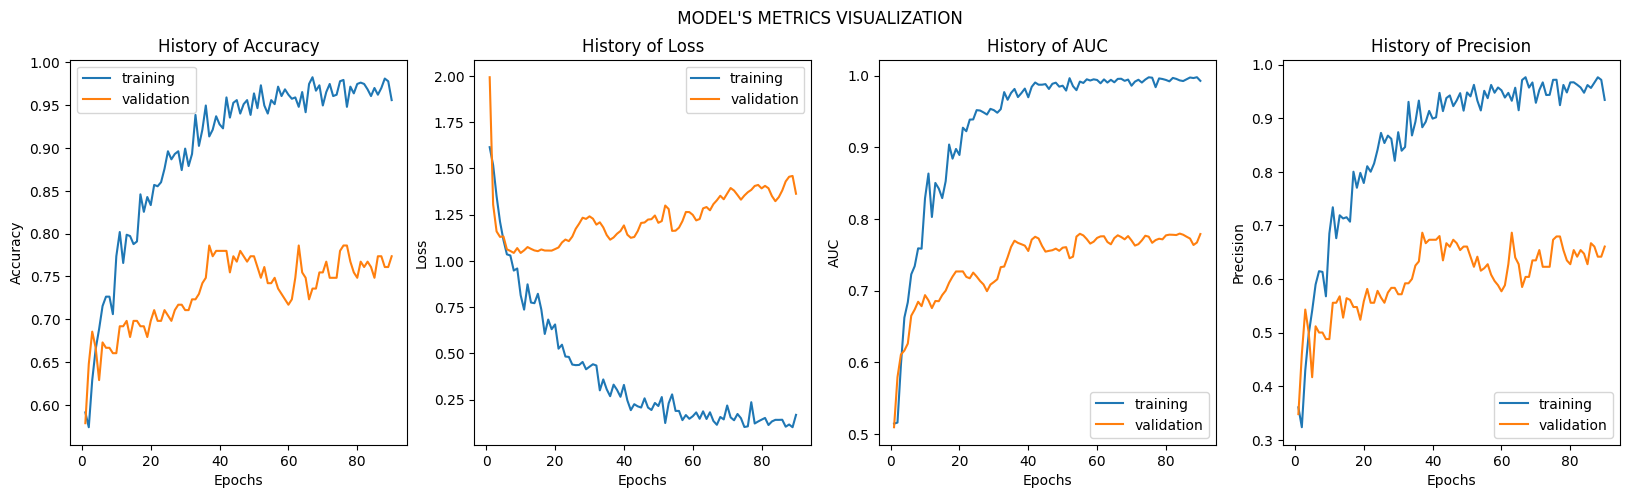

In [151]:


def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])



    plt.show()


Train_Val_Plot(hist.history['accuracy'],hist.history['val_accuracy'],
               hist.history['loss'],hist.history['val_loss'],
               hist.history['auc'],hist.history['val_auc'],
               hist.history['precision'],hist.history['val_precision'],

              )



In [152]:
y_pred = np.argmax(model.predict(test_X), axis=1)

3/3 [==============================] - 1s 167ms/step


Text(0.5, 1.0, 'Confusion Matrix')

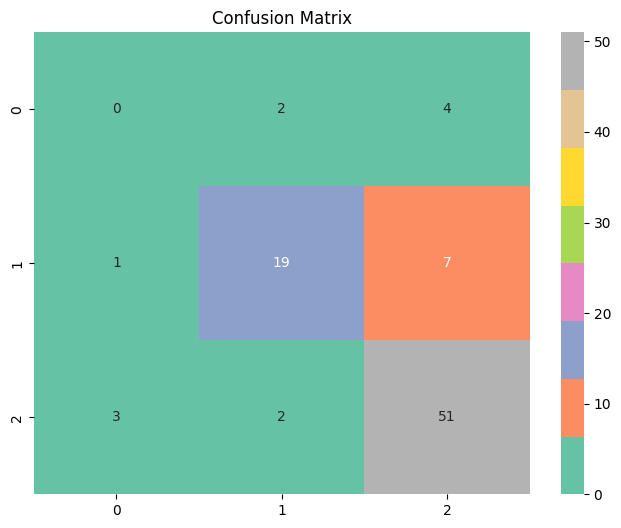

In [153]:
# CONFUSION MATRIX PLOT
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))

# Compute the confusion matrix
c_m = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(c_m, annot=True,cmap='Set2')
plt.title("Confusion Matrix")

In [154]:
print(f"{('Accuracy Score: ')}{accuracy_score(np.argmax(test_y,axis=1),y_pred)}\n")
print(f"{('Classification report')}{classification_report(np.argmax(test_y,axis=1),y_pred)}\n")
print(f"{('F1 Score: ')}{f1_score(np.argmax(test_y,axis=1),y_pred, average=None)}\n")

Accuracy Score: 0.7865168539325843

Classification report              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.83      0.70      0.76        27
           2       0.82      0.91      0.86        56

    accuracy                           0.79        89
   macro avg       0.55      0.54      0.54        89
weighted avg       0.77      0.79      0.77        89


F1 Score: [0.         0.76       0.86440678]



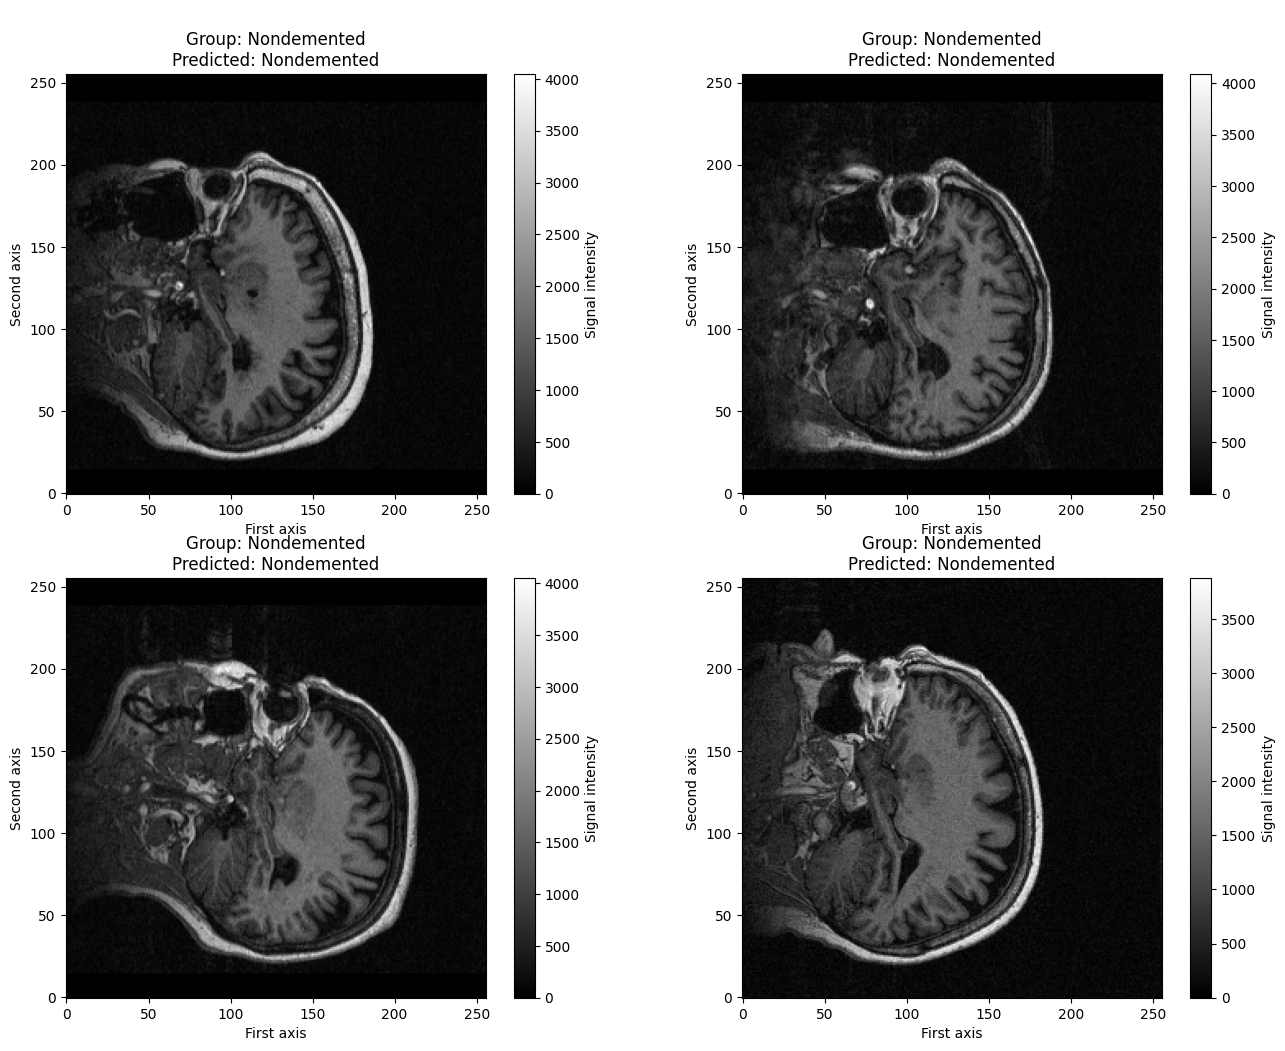

In [155]:
# Plot the 4 images from the test dataset after prediction with its actual and predicted labels

images = [6, 10, 14, 26]
plt.figure(figsize=(16, 12))

for index, image in enumerate(images):
    img_data = test_X[image]

    mri_file_name = mri_patients_scans_names[image]
    true = label_encoder.classes_[np.argmax(test_y, axis=1)[image]]
    actual = label_encoder.classes_[y_pred[image]]

    plt.subplot(2, 2, index+1)
    plt.title(f'\nGroup: {true}\nPredicted: {actual}')
    plt.imshow(img_data[:, :, -1], cmap='gray', origin='lower')
    plt.xlabel('First axis')
    plt.ylabel('Second axis')
    plt.colorbar(label='Signal intensity')
plt.show()